In [1]:
import pandas as pd
import folium
import psycopg2
from dotenv import load_dotenv
import folium
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from prophet import Prophet

In [2]:
load_dotenv('credentials.env')

# Print out the environment variables to confirm they're loaded
print("DB_HOST:", os.getenv("DB_HOST"))
print("DB_NAME:", os.getenv("DB_NAME"))
print("DB_USER:", os.getenv("DB_USER"))
print("DB_PASSWORD:", os.getenv("DB_PASSWORD"))
print("DB_PORT:", os.getenv("DB_PORT"))



DB_HOST: pinot.cs.ucsb.edu
DB_NAME: pinot
DB_USER: cs190nf24g10
DB_PASSWORD: YKUkr3GV
DB_PORT: 5432


In [3]:
wifistats_df = pd.read_csv("./data/wifistats.csv")
extra_info_df = pd.read_csv("./data/extra_info.csv")
devices_df = pd.read_csv("./data/devices.csv")
df = pd.merge(wifistats_df, extra_info_df, on="label", how="inner")
df.head()

,label,time,signal (dBm),packet_loss,connected_time (s),tx_bitrate (MBit/s),rx_bitrate (MBit/s),min_ping_rtt (ms),avg_ping_rtt (ms),max_ping_rtt (ms),mdev_ping_rtt (ms),latitude,longitude
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,-65.0,0.0,546569.0,200.0,150.0,3.308,3.878,4.840,0.572,34.413869,-119.841237
1,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,-66.0,0.0,547196.0,200.0,150.0,3.474,5.106,6.327,0.999,34.413869,-119.841237
2,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,-67.0,0.0,547813.0,200.0,150.0,3.801,4.473,5.712,0.683,34.413869,-119.841237
3,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,-67.0,0.0,548450.0,200.0,121.5,4.044,4.276,4.511,0.150,34.413869,-119.841237
4,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,-66.0,0.0,549078.0,180.0,121.5,3.442,4.189,5.267,0.793,34.413869,-119.841237


In [4]:
print(df.describe())

       signal (dBm)   packet_loss  connected_time (s)  tx_bitrate (MBit/s)  \
count  4.109482e+06  4.109482e+06        4.109482e+06         4.109482e+06   
mean  -5.526922e+01  1.151955e+00        9.763481e+05         1.124416e+02   
std    9.678881e+00  5.435023e+00        1.265951e+06         6.025382e+01   
min   -8.700000e+01  0.000000e+00        0.000000e+00         6.000000e+00   
25%   -6.100000e+01  0.000000e+00        1.664060e+05         6.500000e+01   
50%   -5.600000e+01  0.000000e+00        5.210225e+05         7.220000e+01   
75%   -5.100000e+01  0.000000e+00        1.292515e+06         1.800000e+02   
max   -1.900000e+01  1.000000e+02        1.274013e+07         2.000000e+02   

       rx_bitrate (MBit/s)  min_ping_rtt (ms)  avg_ping_rtt (ms)  \
count         4.109482e+06       4.109421e+06       4.109421e+06   
mean          1.092572e+02       3.353664e+00       7.096531e+00   
std           7.056793e+01       9.240721e+00       2.657750e+01   
min           6.000000e+0

In [6]:
wifi_df = df[['label', 'time', 'signal (dBm)', 'packet_loss']].sample(n=5000).copy()
wifi_df['time'] = pd.to_datetime(wifi_df['time'])
fig_signal = px.line(wifi_df, 
                     x='time', 
                     y='signal (dBm)', 
                     color='label',
                     color_discrete_sequence=px.colors.qualitative.Set3,
                     title='Signal Strength Over Time', 
                     labels={'signal (dBm)': 'Signal Strength (dBm)',
                            'label': 'Device'})
fig_signal.update_layout(
    showlegend=True,
    legend_title_text='Device',
    height=600
)
fig_signal.update_xaxes(rangeslider_visible=True)
fig_signal.show()
fig_loss = px.line(wifi_df, 
                   x='time', 
                   y='packet_loss', 
                   color='label',
                   color_discrete_sequence=px.colors.qualitative.Set3,
                   title='Packet Loss Over Time', 
                   labels={'packet_loss': 'Packet Loss (%)',
                          'label': 'Device'})
fig_loss.update_layout(
    showlegend=True,
    legend_title_text='Device',
    height=600
)
fig_loss.update_xaxes(rangeslider_visible=True)
fig_loss.show()

In [20]:
try:
    cur = conn.cursor()
    query = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'wifistats';
    """
    cur.execute(query)
    columns = cur.fetchall()
    column_names = [col[0] for col in columns]
    print("Column Titles in 'wifistats':")
    for col in column_names:
        print(col)
except Exception as e:
    print("Error fetching column titles.")
    print("Error:", e)

Column Titles in 'wifistats':
signal
time
packet_loss
rx_bitrate
connected_time
tx_bitrate
ping
label


In [21]:
def print_column_titles(table_name):
    try:
        cur = conn.cursor()
        query = f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_name = '{table_name}';
        """
        cur.execute(query)
        columns = cur.fetchall()

        if columns:
            print(f"Column Titles in '{table_name}':")
            for col in columns:
                print(col[0])
        else:
            print(f"No columns found for table '{table_name}'.")
    except Exception as e:
        print(f"Error fetching column titles for table '{table_name}'.")
        print("Error:", e)
tables = ["wifistats", "devices", "extra_info"]
for table in tables:
    print_column_titles(table)
    print() 

Column Titles in 'wifistats':
signal
time
packet_loss
rx_bitrate
connected_time
tx_bitrate
ping
label

Column Titles in 'devices':
wireless_bytes
wired_bytes
last_seen
location
tags
label
uptime
comment
ethernet_mac
wlan_mac

Column Titles in 'extra_info':
latitude
longtitude
label
comment
contact_person



In [26]:
try:
    cur = conn.cursor()
    telemetry_query = """
    SELECT label, time, signal, rx_bitrate, tx_bitrate, packet_loss
    FROM public.wifistats
    LIMIT 1000; -- Adjust limit as needed for testing or full analysis
    """
    cur.execute(telemetry_query)
    telemetry_data = cur.fetchall()
    telemetry_df = pd.DataFrame(telemetry_data, columns=['label', 'time', 'signal', 'rx_bitrate', 'tx_bitrate', 'packet_loss'])
    location_query = """
    SELECT label, latitude, longtitude
    FROM public.extra_info
    WHERE latitude IS NOT NULL AND longtitude IS NOT NULL;
    """
    cur.execute(location_query)
    location_data = cur.fetchall()
    location_df = pd.DataFrame(location_data, columns=['label', 'latitude', 'longitude'])

except Exception as e:
    print("Error fetching data.")
    print("Error:", e)
telemetry_df['time'] = pd.to_datetime(telemetry_df['time'])
telemetry_df = telemetry_df.merge(location_df, on='label', how='inner')
telemetry_df['signal'] = telemetry_df['signal'].replace('None', np.nan).astype(float)
telemetry_df['rx_bitrate'] = (
    telemetry_df['rx_bitrate']
    .replace('None', np.nan)
    .str.extract(r'([\d\.]+)')  
    .astype(float)
)
telemetry_df['tx_bitrate'] = (
    telemetry_df['tx_bitrate']
    .replace('None', np.nan)
    .str.extract(r'([\d\.]+)') 
    .astype(float)
)
telemetry_df['packet_loss'] = telemetry_df['packet_loss'].replace('None', np.nan).astype(float)
heatmap = folium.Map(location=[34.4140, -119.8489], zoom_start=14) 

for _, row in telemetry_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if row['signal'] > -60 else 'red', 
        fill=True,
        fill_opacity=0.7,
        popup=f"""
        Device: {row['label']}<br>
        Signal: {row['signal']} dBm<br>
        RX Bitrate: {row['rx_bitrate']} MBit/s<br>
        TX Bitrate: {row['tx_bitrate']} MBit/s<br>
        Packet Loss: {row['packet_loss']}%
        """
    ).add_to(heatmap)
heatmap.save("network_performance_heatmap.html")
print("Heatmap saved as 'network_performance_heatmap.html'.")

Heatmap saved as 'network_performance_heatmap.html'.


15:44:48 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] done processing


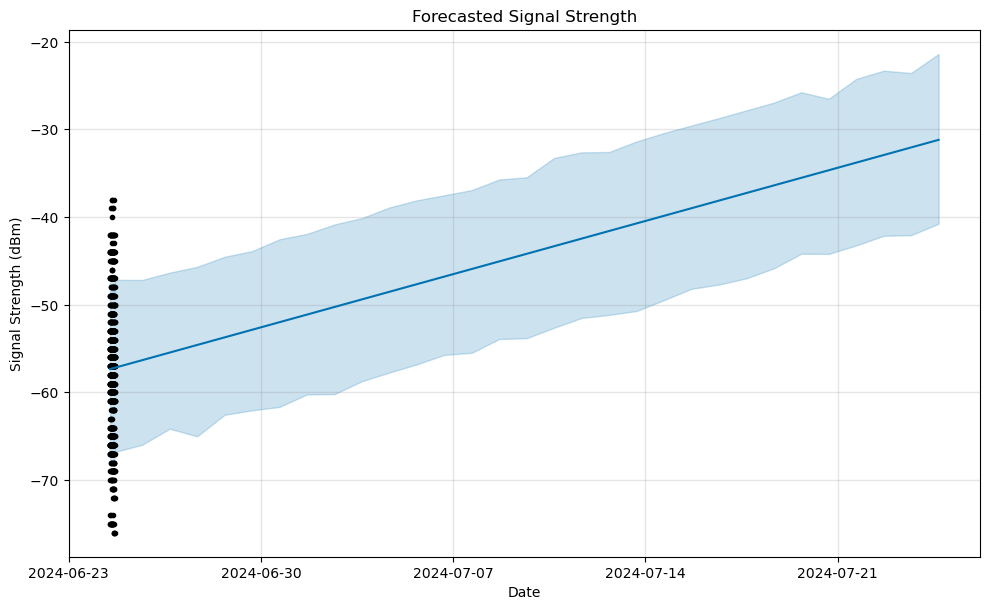

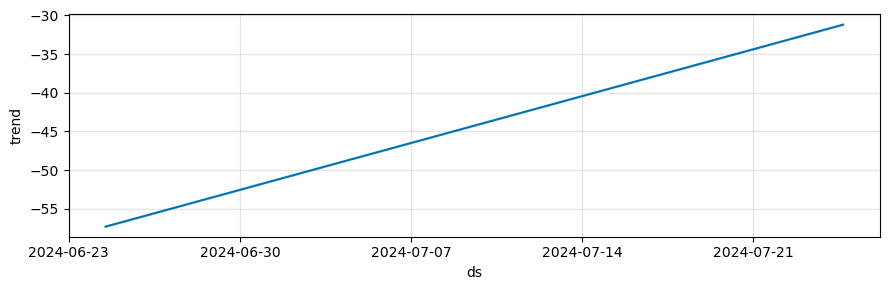

Forecast saved to 'forecasted_signal_strength.csv'.


In [32]:
telemetry_df = telemetry_df.sort_values(by='time')
telemetry_df['time'] = pd.to_datetime(telemetry_df['time']) 
signal_df = telemetry_df[['time', 'signal']].dropna()
signal_df = signal_df.rename(columns={'time': 'ds', 'signal': 'y'}) 
model = Prophet()
model.fit(signal_df)

future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)
fig = model.plot(forecast)
plt.title('Forecasted Signal Strength')
plt.xlabel('Date')
plt.ylabel('Signal Strength (dBm)')
plt.show()
fig_components = model.plot_components(forecast)
plt.show()
forecast.to_csv('forecasted_signal_strength.csv', index=False)
print("Forecast saved to 'forecasted_signal_strength.csv'.")

Data Quality Analysis
Total Records: 1000

Missing Values:
label          0
time           0
signal         0
rx_bitrate     0
tx_bitrate     0
packet_loss    0
latitude       0
longitude      0
dtype: int64

Temporal Distribution of Data:
2024-06-24    1000
Freq: D, Name: time, dtype: int64


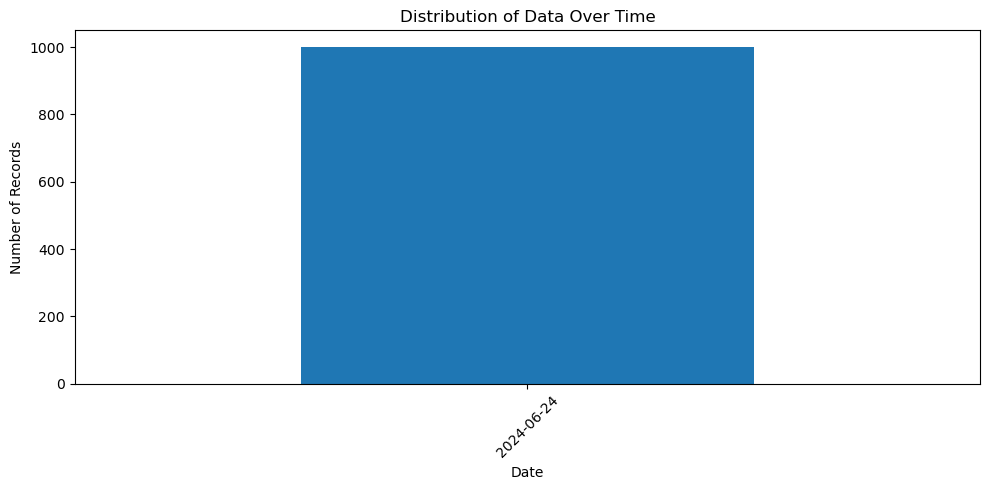


Summary Statistics for Key Metrics:
            signal   rx_bitrate   tx_bitrate  packet_loss
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    -57.254000   104.727900   118.383200     0.740000
std       7.330841    75.427862    61.832787     4.082777
min     -76.000000     6.500000    14.400000     0.000000
25%     -61.000000    39.000000    65.000000     0.000000
50%     -57.000000    72.200000    72.200000     0.000000
75%     -53.000000   200.000000   180.000000     0.000000
max     -38.000000   200.000000   200.000000    40.000000


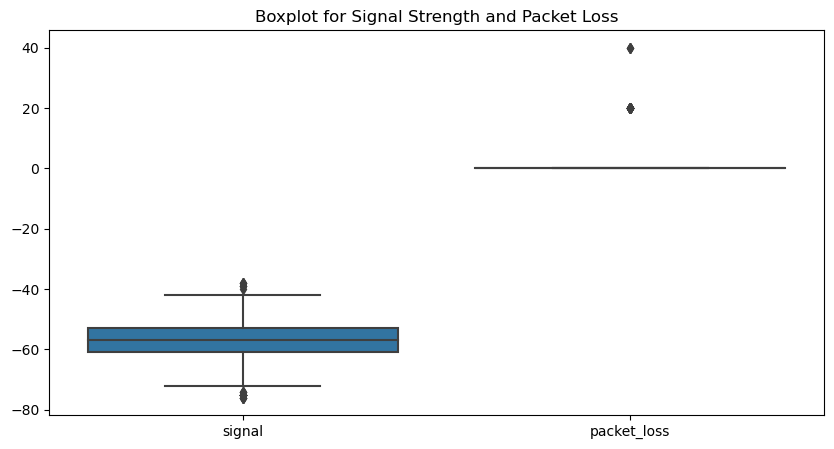

In [33]:
print("Data Quality Analysis")
print("Total Records:", telemetry_df.shape[0])
missing_values = telemetry_df.isnull().sum()
print("\nMissing Values:")
print(missing_values)
print("\nTemporal Distribution of Data:")
telemetry_df['time'] = pd.to_datetime(telemetry_df['time'])
time_distribution = telemetry_df['time'].dt.to_period('D').value_counts().sort_index()
print(time_distribution)
plt.figure(figsize=(10, 5))
time_distribution.plot(kind='bar')
plt.title("Distribution of Data Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

numeric_summary = telemetry_df[['signal', 'rx_bitrate', 'tx_bitrate', 'packet_loss']].describe()
print("\nSummary Statistics for Key Metrics:")
print(numeric_summary)
plt.figure(figsize=(10, 5))
sns.boxplot(data=telemetry_df[['signal', 'packet_loss']])
plt.title("Boxplot for Signal Strength and Packet Loss")
plt.show()